In [1]:
!pip install nltk vaderSentiment yfinance -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the punkt_tab model for tokenization


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        return ' '.join(tokens)
    return ""

# Load your dataset
df = pd.read_csv('/content/dataset_52-person-from-2021-02-05_2023-06-12_21-34-17-266_with_sentiment.csv', encoding='ISO-8859-1')
df = df.dropna(subset=['full_text'])
df['clean_text'] = df['full_text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
df.head()

,Unnamed: 0,created_at,favorite_count,full_text,reply_count,retweet_count,clean_text,importance_coefficient,importance_coefficient_normalized,new_coins,scores,compound,sentiment_type
0,32666,2/1/2021,154,#privacy is a human right. learn how to make y...,18,23,privacy human right learn make bitcoin transac...,340.0,0.000588,(bitcoin),"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
1,29639,2/1/2021,17,"overall btc trading volume has increased, but ...",1,5,overall btc trading volume increased average t...,39.5,0.000068,(btc),"{'neg': 0.0, 'neu': 0.95, 'pos': 0.05, 'compou...",0.2124,POSITIVE
2,29613,2/1/2021,3,"on average, the return distribution of btc ske...",0,1,average return distribution btc skews slightly...,7.0,0.000012,(btc),"{'neg': 0.053, 'neu': 0.769, 'pos': 0.177, 'co...",0.7010,POSITIVE
3,39638,2/1/2021,3496,i sent some! https://t.co/mfyrz35zjf\n\nyou sh...,731,686,sent httpstcomfyrzzjf givedirectly great work ...,8043.5,0.013905,(doge),"{'neg': 0.06, 'neu': 0.856, 'pos': 0.084, 'com...",0.2225,POSITIVE
4,32660,2/1/2021,0,rt @reg_mati: la privacidad es un derecho huma...,0,7,rt regmati la privacidad e un derecho humano m...,7.0,0.000012,(bitcoin),"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL


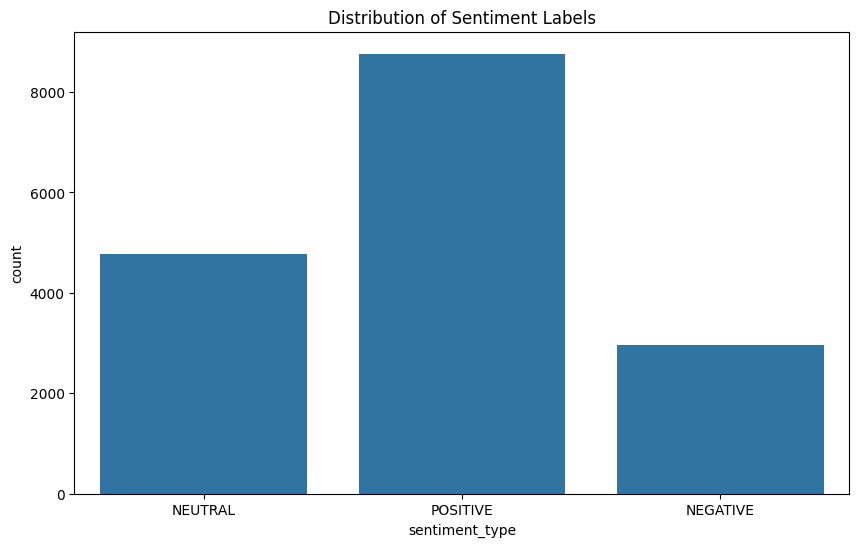

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from statsmodels.tsa.stattools import ccf
# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_type', data=df)
plt.title('Distribution of Sentiment Labels')
plt.show()

In [5]:
print(f"Total entries: {len(df)}")
print(f"Unique sentiments: {df['sentiment_type'].nunique()}")
print(f"Date range: {df['created_at'].min()} to {df['created_at'].max()}")

Total entries: 16512
Unique sentiments: 3
Date range: 1/1/2022 to 9/9/2022


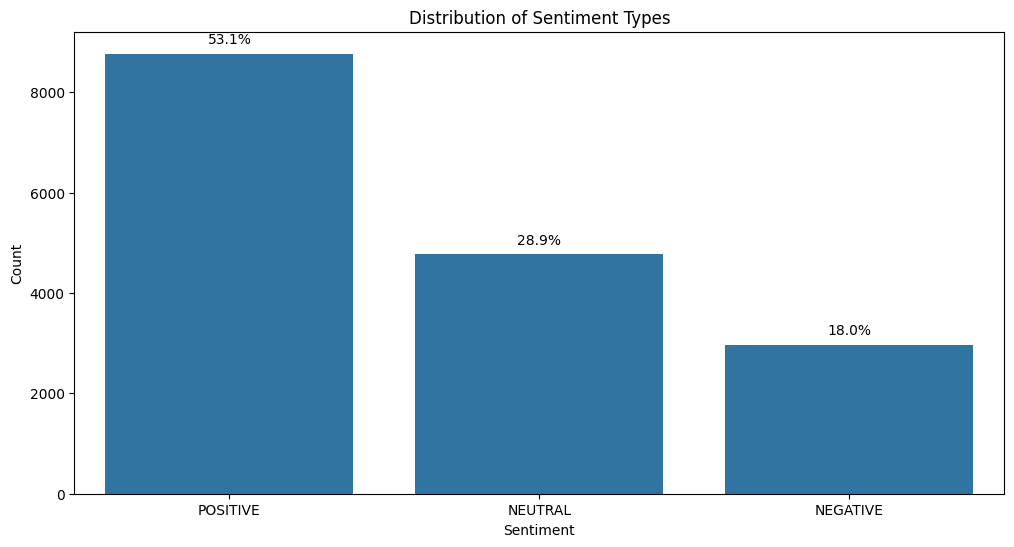

In [6]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x='sentiment_type', data=df, order=df['sentiment_type'].value_counts().index)
plt.title('Distribution of Sentiment Types')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0,10), textcoords='offset points')
plt.show()

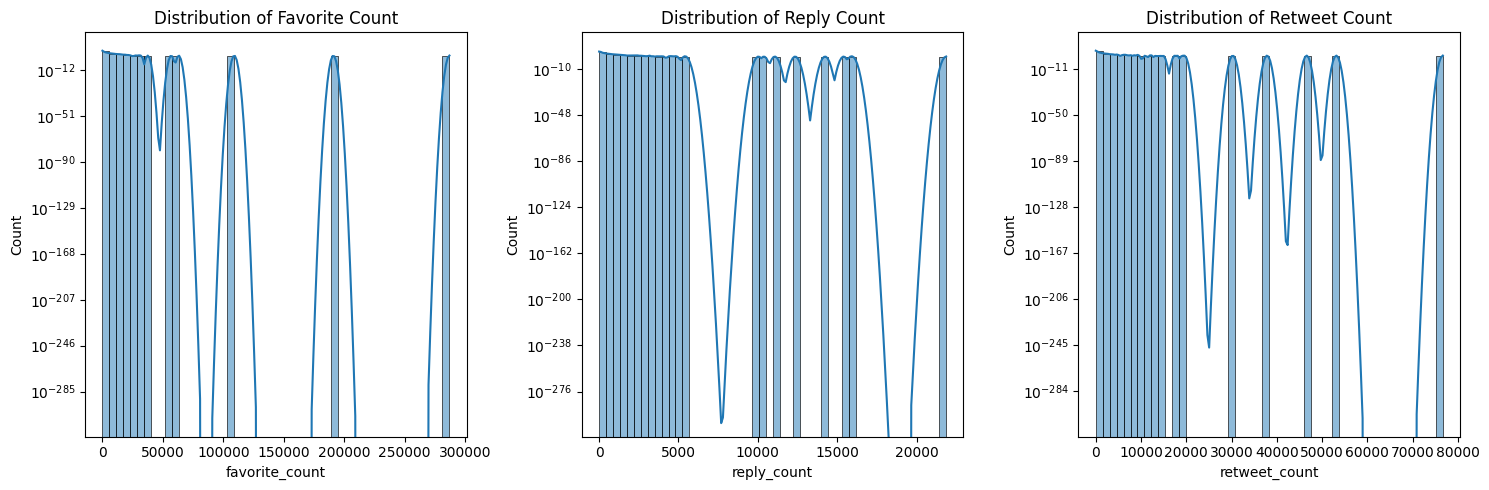

In [7]:
engagement_metrics = ['favorite_count', 'reply_count', 'retweet_count']
plt.figure(figsize=(15,5))
for i, col in enumerate(engagement_metrics, 1):
    plt.subplot(1,3,i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.yscale('log')  # Many social metrics have long-tailed distributions
plt.tight_layout()
plt.show()

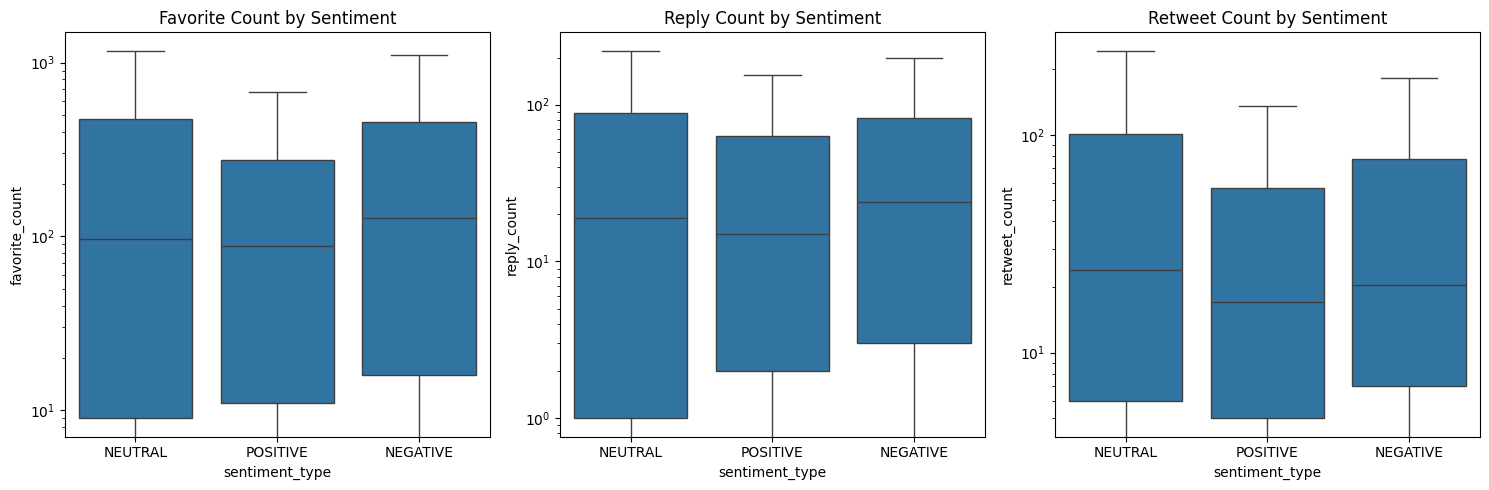

In [8]:
plt.figure(figsize=(15,5))
for i, metric in enumerate(engagement_metrics, 1):
    plt.subplot(1,3,i)
    sns.boxplot(x='sentiment_type', y=metric, data=df, showfliers=False)
    plt.title(f'{metric.replace("_", " ").title()} by Sentiment')
    plt.yscale('log')
plt.tight_layout()
plt.show()

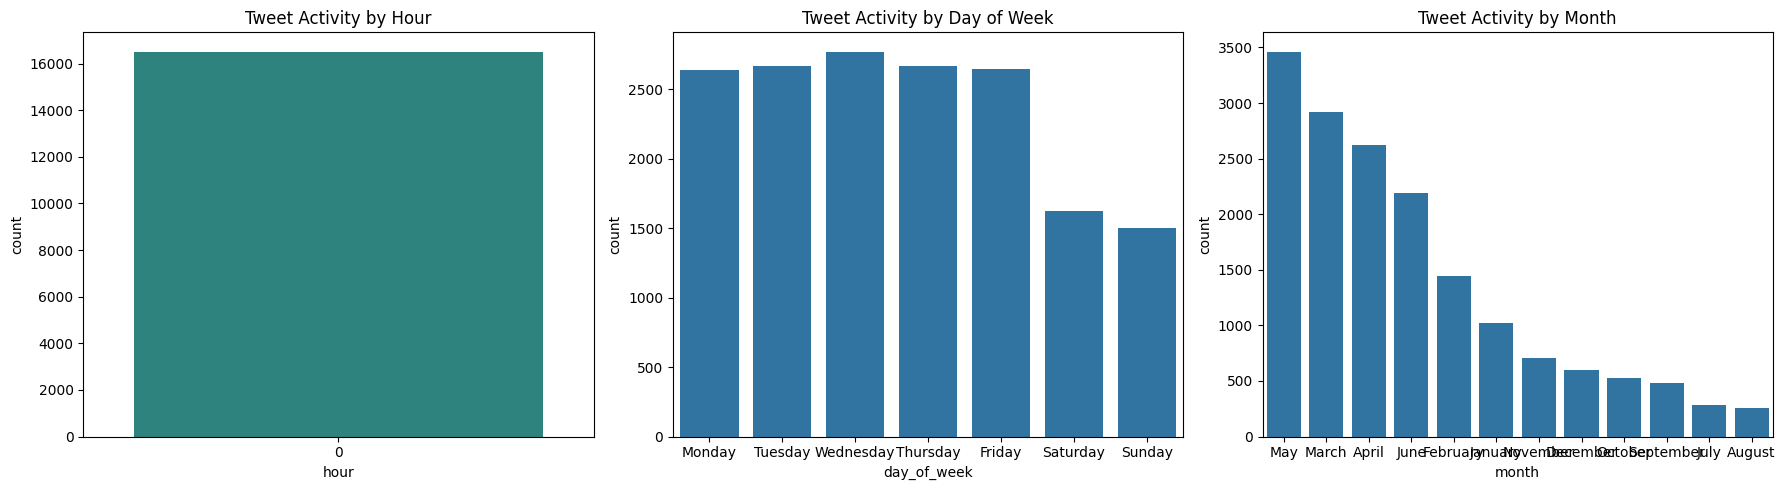

In [9]:
# Convert to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Extract time features
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.day_name()
df['month'] = df['created_at'].dt.month_name()

# Plot temporal patterns
plt.figure(figsize=(18,5))

# Hourly distribution
plt.subplot(1,3,1)
sns.countplot(x='hour', data=df, palette='viridis',
              hue='hour', legend=False)
plt.title('Tweet Activity by Hour')

# Weekly distribution
plt.subplot(1,3,2)
sns.countplot(x='day_of_week', data=df,
             order=['Monday','Tuesday','Wednesday',
                    'Thursday','Friday','Saturday','Sunday'])
plt.title('Tweet Activity by Day of Week')

# Monthly distribution
plt.subplot(1,3,3)
sns.countplot(x='month', data=df, order=df['month'].value_counts().index)
plt.title('Tweet Activity by Month')
plt.tight_layout()
plt.show()

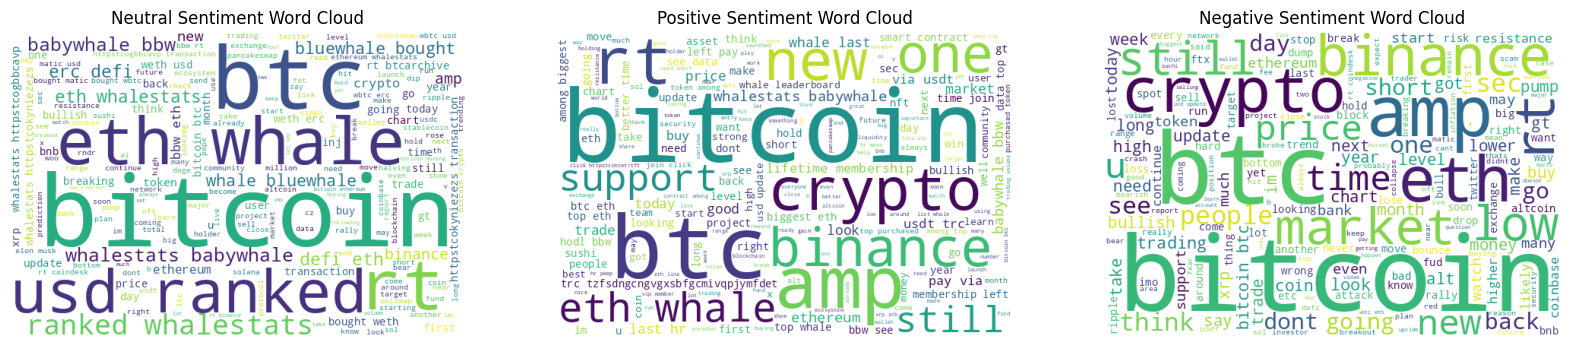

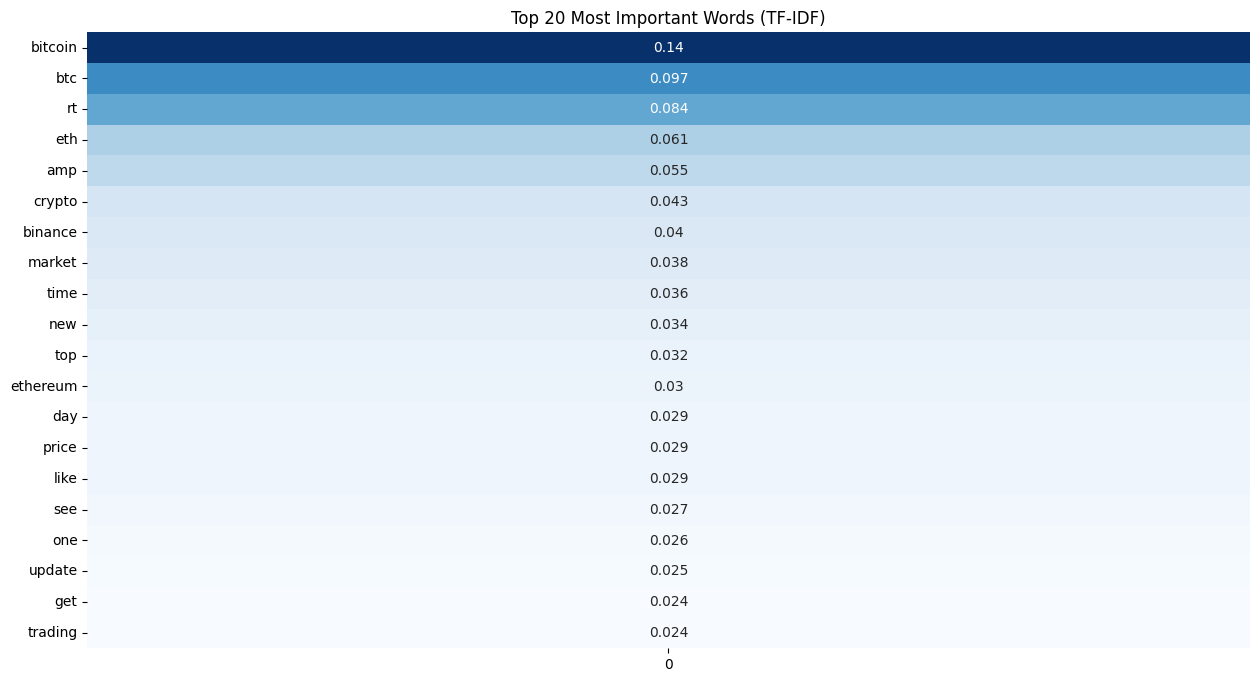

In [10]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Generate word clouds for each sentiment
sentiments = df['sentiment_type'].unique()
plt.figure(figsize=(20,10))

for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(1,len(sentiments),i)
    text = ' '.join(df[df['sentiment_type']==sentiment]['clean_text'])
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud)
    plt.title(f'{sentiment.capitalize()} Sentiment Word Cloud')
    plt.axis('off')
plt.show()

# TF-IDF Analysis
tfidf = TfidfVectorizer(max_features=50)
tfidf_matrix = tfidf.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

plt.figure(figsize=(15,8))
sns.heatmap(tfidf_df.mean().sort_values(ascending=False).head(20).to_frame(),
            annot=True, cmap='Blues', cbar=False)
plt.title('Top 20 Most Important Words (TF-IDF)')
plt.show()

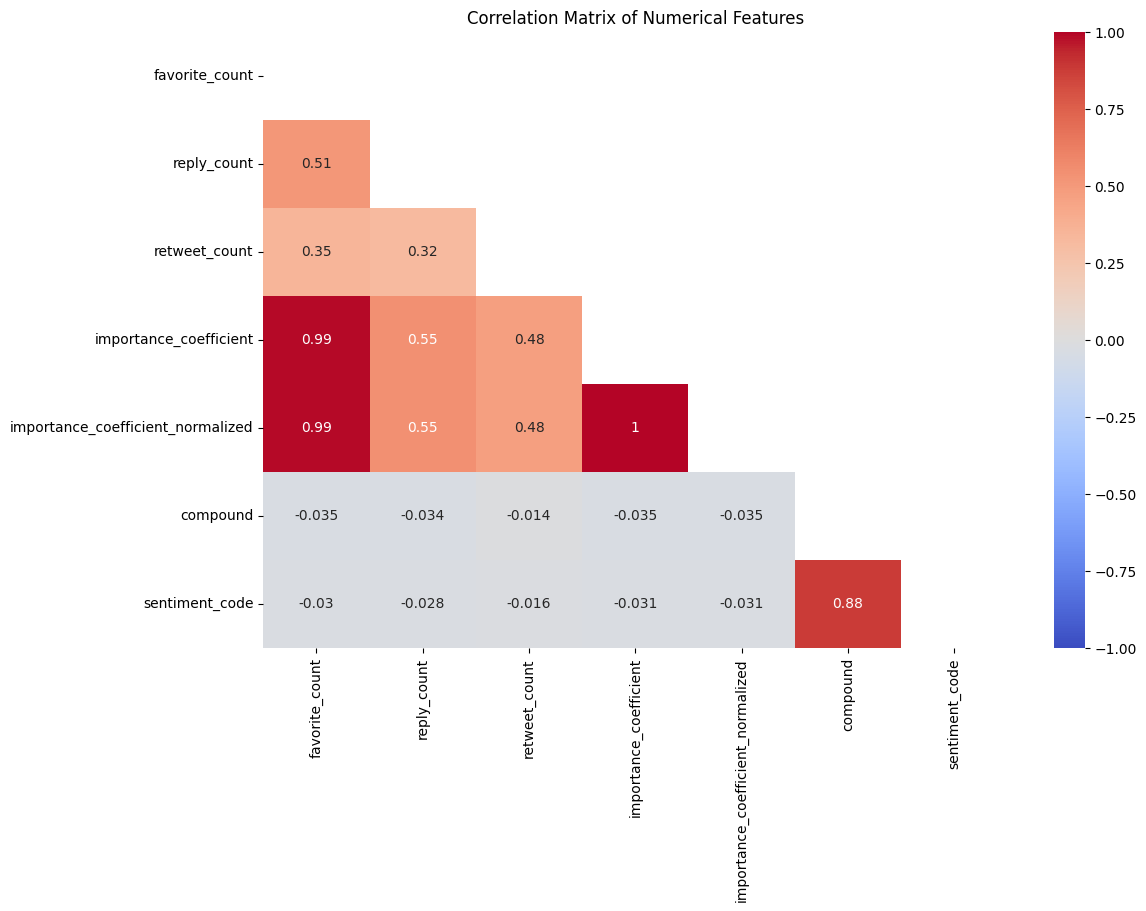

In [11]:
# Convert categorical features to numerical
df['sentiment_code'] = df['sentiment_type'].astype('category').cat.codes

# Select numerical features
numerical_features = ['favorite_count', 'reply_count', 'retweet_count',
                     'importance_coefficient', 'importance_coefficient_normalized',
                     'compound', 'sentiment_code']

plt.figure(figsize=(12,8))
corr_matrix = df[numerical_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

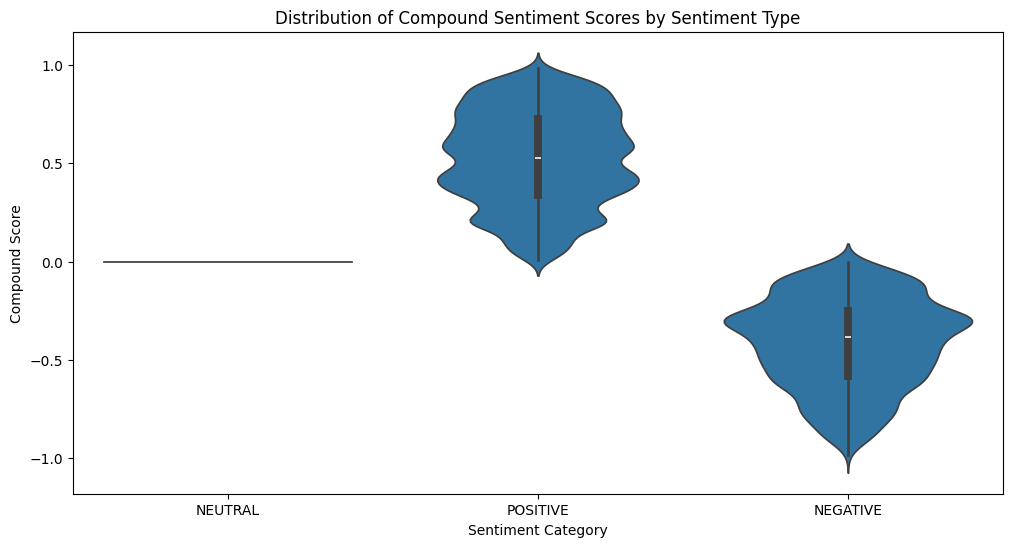

In [12]:
plt.figure(figsize=(12,6))
sns.violinplot(x='sentiment_type', y='compound', data=df)
plt.title('Distribution of Compound Sentiment Scores by Sentiment Type')
plt.ylabel('Compound Score')
plt.xlabel('Sentiment Category')
plt.show()

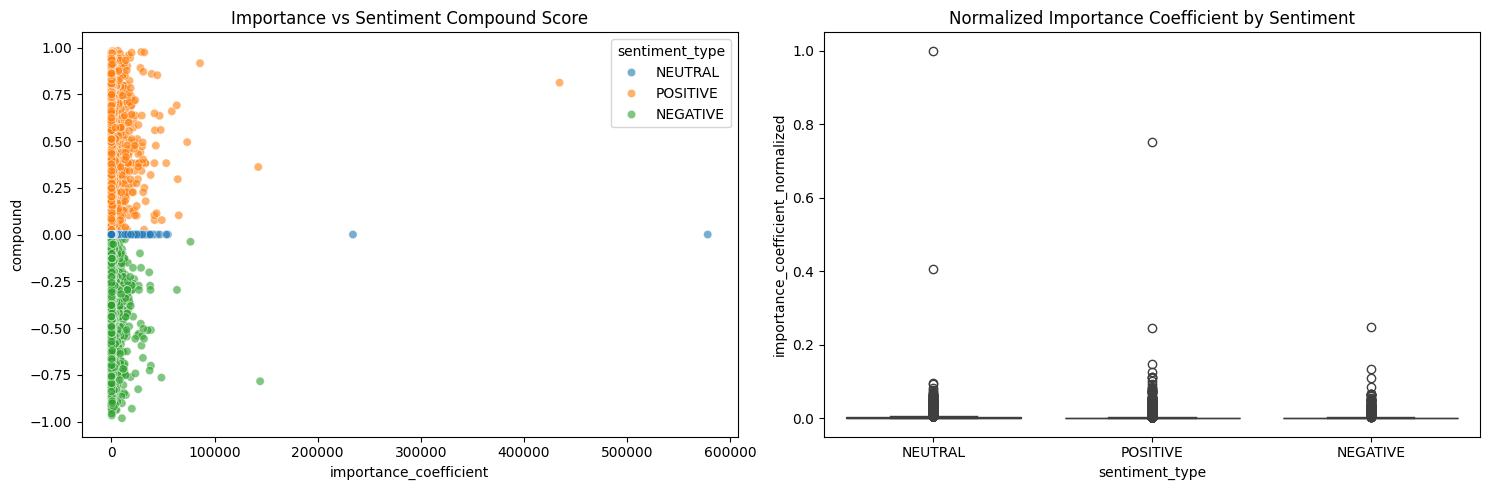

In [13]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.scatterplot(x='importance_coefficient', y='compound',
                hue='sentiment_type', data=df, alpha=0.6)
plt.title('Importance vs Sentiment Compound Score')

plt.subplot(1,2,2)
sns.boxplot(x='sentiment_type',
            y='importance_coefficient_normalized', data=df)
plt.title('Normalized Importance Coefficient by Sentiment')
plt.tight_layout()
plt.show()

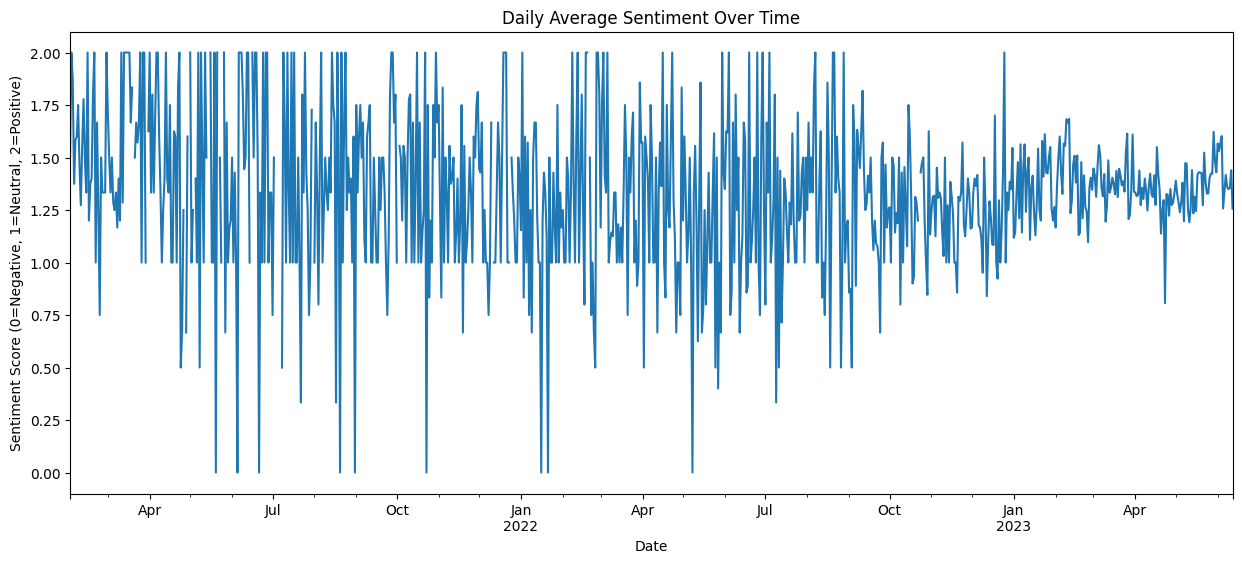

In [14]:
# Resample to daily frequency
daily_sentiment = df.set_index('created_at').resample('D')['sentiment_code'].mean()

plt.figure(figsize=(15,6))
daily_sentiment.plot()
plt.title('Daily Average Sentiment Over Time')
plt.ylabel('Sentiment Score (0=Negative, 1=Neutral, 2=Positive)')
plt.xlabel('Date')
plt.show()

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_type'] = df['clean_text'].apply(vader_sentiment)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

X = df['clean_text']
y = df['sentiment_type']

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_pred)
nb_f1 = f1_score(y_test, y_pred, average='weighted')
nb_precision = precision_score(y_test, y_pred, average='weighted')
nb_recall = recall_score(y_test, y_pred, average='weighted')
nb_roc_auc = roc_auc_score(y_test, nb_model.predict_proba(X_test), multi_class='ovr')

print(f"Naive Bayes Metrics:")
print(f"Accuracy: {nb_accuracy:.2f}")
print(f"F1 Score: {nb_f1:.2f}")
print(f"Precision: {nb_precision:.2f}")
print(f"Recall: {nb_recall:.2f}")
print(f"ROC AUC Score: {nb_roc_auc:.2f}")
print("--------------------------------------")

preds = nb_model.predict(X_test)
print(classification_report(y_test, preds))

Naive Bayes Metrics:
Accuracy: 0.69
F1 Score: 0.66
Precision: 0.73
Recall: 0.69
ROC AUC Score: 0.88
--------------------------------------
              precision    recall  f1-score   support

    negative       0.78      0.33      0.46       537
     neutral       0.83      0.40      0.54       966
    positive       0.66      0.96      0.78      1800

    accuracy                           0.69      3303
   macro avg       0.75      0.56      0.59      3303
weighted avg       0.73      0.69      0.66      3303



In [17]:
!pip install transformers -q

from transformers import pipeline

# Load lightweight sentiment pipeline
classifier = pipeline("sentiment-analysis",
                      model="distilbert-base-uncased-finetuned-sst-2-english")

def distilbert_sentiment(text):
    try:
        result = classifier(text[:512])[0]  # Truncate to 512 tokens
        return result['label'].lower()
    except:
        return 'neutral'

df['sentiment_type'] = df['clean_text'].apply(distilbert_sentiment)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [18]:
import yfinance as yf
import pandas as pd

# Download Bitcoin data
btc = yf.download('BTC-USD', start='2022-01-01', end='2023-12-31')
# Force btc to have a single-level index with 'Date' as a column
btc = btc.reset_index()
print("btc DataFrame structure after download and reset_index:")
print(btc.head())  # Print the first few rows of btc
print(btc.columns) # Print the columns of btc

# Assuming 'created_at' is your date column in df
df['date'] = pd.to_datetime(df['created_at']).dt.date
btc['Date'] = pd.to_datetime(btc['Date']).dt.date

# Convert 'date' columns to strings
df['date'] = df['date'].astype(str)
btc['Date'] = btc['Date'].astype(str)

print("\ndf['date'] column details:")
print(df['date'].head())  # Print the first few values of df['date']
print(df['date'].dtype)  # Print the data type of df['date']

print("\nbtc['Date'] column details:")
print(btc['Date'].head())  # Print the first few values of btc['Date']
print(btc['Date'].dtype)  # Print the data type of btc['Date']

<ipython-input-18-2303628127>:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2022-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed

btc DataFrame structure after download and reset_index:
Price        Date         Close          High           Low          Open  \
Ticker                  BTC-USD       BTC-USD       BTC-USD       BTC-USD   
0      2022-01-01  47686.812500  47827.312500  46288.484375  46311.746094   
1      2022-01-02  47345.218750  47881.406250  46856.937500  47680.925781   
2      2022-01-03  46458.117188  47510.726562  45835.964844  47343.542969   
3      2022-01-04  45897.574219  47406.546875  45752.464844  46458.851562   
4      2022-01-05  43569.003906  46929.046875  42798.222656  45899.359375   

Price        Volume  
Ticker      BTC-USD  
0       24582667004  
1       27951569547  
2       33071628362  
3       42494677905  
4       36851084859  
MultiIndex([(  'Date',        ''),
            ( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])



In [19]:
# Calculate daily sentiment
daily_sentiment = df.groupby('date')['sentiment_type'].value_counts(normalize=True).unstack().fillna(0)
daily_sentiment = daily_sentiment.reset_index()

print("\ndaily_sentiment DataFrame structure:")
print(daily_sentiment.head())  # Print the first few rows of daily_sentiment
print(daily_sentiment.columns) # Print the columns of daily_sentiment


daily_sentiment DataFrame structure:
sentiment_type        date  negative  positive
0               2021-02-01     0.875     0.125
1               2021-02-02     1.000     0.000
2               2021-02-03     0.750     0.250
3               2021-02-04     0.750     0.250
4               2021-02-05     0.750     0.250
Index(['date', 'negative', 'positive'], dtype='object', name='sentiment_type')


In [20]:
btc = btc.droplevel(level=0, axis=1) if isinstance(btc.columns, pd.MultiIndex) else btc  # Drop extra level if exists
daily_sentiment.columns = daily_sentiment.columns.get_level_values(0) if isinstance(daily_sentiment.columns, pd.MultiIndex) else daily_sentiment.columns # Drop extra level if exists

In [21]:
import yfinance as yf
import pandas as pd

# Download Bitcoin data
btc = yf.download('BTC-USD', start='2022-01-01', end='2023-12-31')
# Force btc to have a single-level index with 'Date' as a column
btc = btc.reset_index()


df['date'] = pd.to_datetime(df['created_at']).dt.date
btc['Date'] = pd.to_datetime(btc['Date']).dt.date

# Convert 'date' columns to strings for merging
df['date'] = df['date'].astype(str)
btc['Date'] = btc['Date'].astype(str)

# Calculate daily sentiment
daily_sentiment = df.groupby('date')['sentiment_type'].value_counts(normalize=True).unstack().fillna(0)
daily_sentiment = daily_sentiment.reset_index()

# Ensure both 'Date' columns are at the same level and type
btc.columns = btc.columns.get_level_values(0) if isinstance(btc.columns, pd.MultiIndex) else btc.columns
daily_sentiment.columns = daily_sentiment.columns.get_level_values(0) if isinstance(daily_sentiment.columns, pd.MultiIndex) else daily_sentiment.columns


# Merge DataFrames using 'inner' join on 'Date' column
merged = pd.merge(btc, daily_sentiment, left_on='Date', right_on='date', how='inner')

# Drop the redundant 'date' column after merging
merged = merged.drop(columns=['date'])

# Print some info for debugging
print("btc columns:", btc.columns)
print("daily_sentiment columns:", daily_sentiment.columns)
print("merged columns:", merged.columns)



# Calculate and print correlation

# Ensure merged DataFrame has the expected columns
if 'Close' in merged.columns and 'positive' in merged.columns and 'negative' in merged.columns:
    correlation = merged[['Close', 'positive', 'negative']].corr()  # Include only available columns
    print("\nCorrelation Matrix:")
    print(correlation)
else:
    print("Error: Expected columns not found in merged DataFrame.")
# ---END MODIFIED SECTION--- #

<ipython-input-21-1704012592>:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2022-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed

btc columns: Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
daily_sentiment columns: Index(['date', 'negative', 'positive'], dtype='object', name='sentiment_type')
merged columns: Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'negative',
       'positive'],
      dtype='object')

Correlation Matrix:
             Close  positive  negative
Close     1.000000 -0.125953  0.125953
positive -0.125953  1.000000 -1.000000
negative  0.125953 -1.000000  1.000000


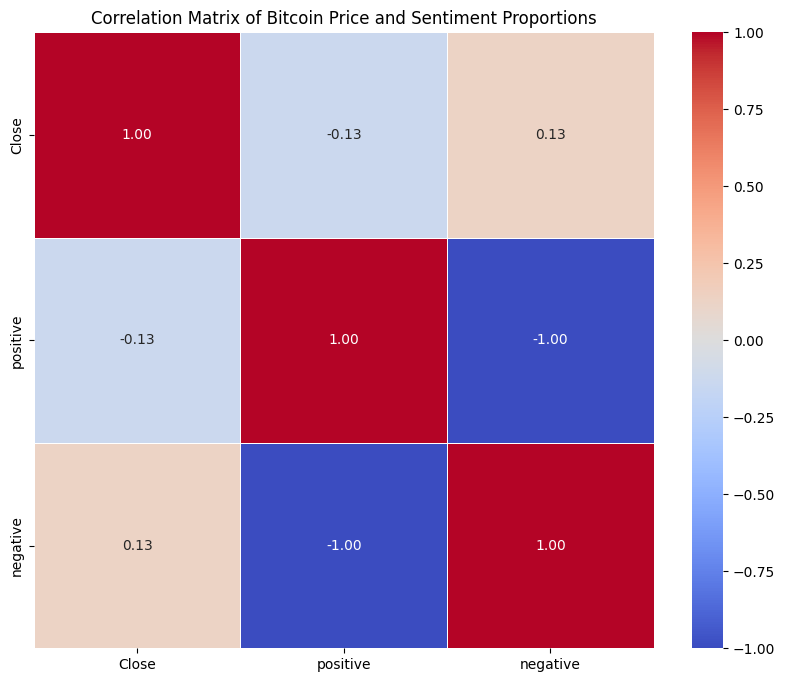

In [22]:
numerical_cols_for_corr = ['Close', 'positive', 'negative', 'neutral']

# Ensure these columns exist in the merged dataframe before calculating correlation
present_cols = [col for col in numerical_cols_for_corr if col in merged.columns]

if present_cols:
    # Calculate the correlation matrix for the selected numerical columns
    correlation_matrix = merged[present_cols].corr()

    # Plot the correlation matrix using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Bitcoin Price and Sentiment Proportions')
    plt.show()
else:
    print("No numerical or sentiment columns found in the merged dataframe to calculate correlation.")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

#  `X_tfidf` and `y` are already defined (from earlier step)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Evaluate Linear Regression
y_pred = logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_f1 = f1_score(y_test, y_pred, average='weighted')
logreg_precision = precision_score(y_test, y_pred, average='weighted')
logreg_recall = recall_score(y_test, y_pred, average='weighted')
logreg_roc_auc = roc_auc_score(y_test,
                               logreg.predict_proba(X_test),
                               multi_class='ovr')

print(f"Logistic Regression Metrics:")
print(f"Accuracy: {logreg_accuracy:.2f}")
print(f"F1 Score: {logreg_f1:.2f}")
print(f"Precision: {logreg_precision:.2f}")
print(f"Recall: {logreg_recall:.2f}")
print(f"ROC AUC Score: {logreg_roc_auc:.2f}")

log_preds = logreg.predict(X_test)
print("Logistic Regression Results:\n", classification_report(y_test, log_preds))

Logistic Regression Metrics:
Accuracy: 0.82
F1 Score: 0.81
Precision: 0.82
Recall: 0.82
ROC AUC Score: 0.93
Logistic Regression Results:
               precision    recall  f1-score   support

    negative       0.80      0.51      0.62       537
     neutral       0.82      0.79      0.81       966
    positive       0.82      0.93      0.87      1800

    accuracy                           0.82      3303
   macro avg       0.81      0.74      0.77      3303
weighted avg       0.82      0.82      0.81      3303



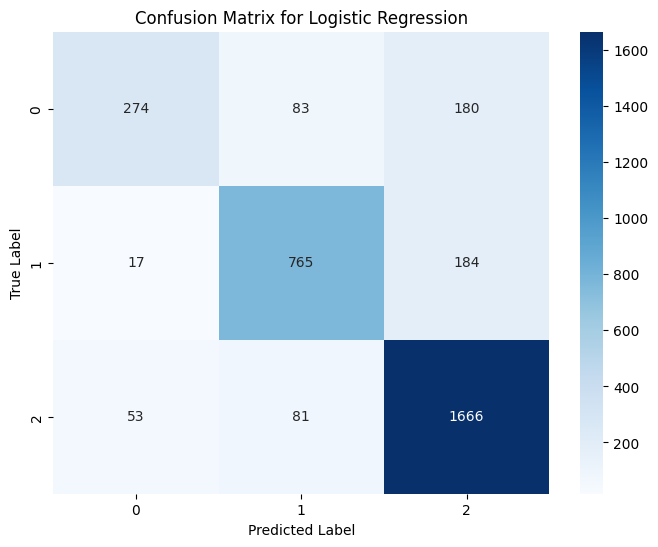

In [ ]:
from sklearn.metrics import confusion_matrix
# Plot confusion matrix for Logistic Regression
conf_matrix_logreg = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

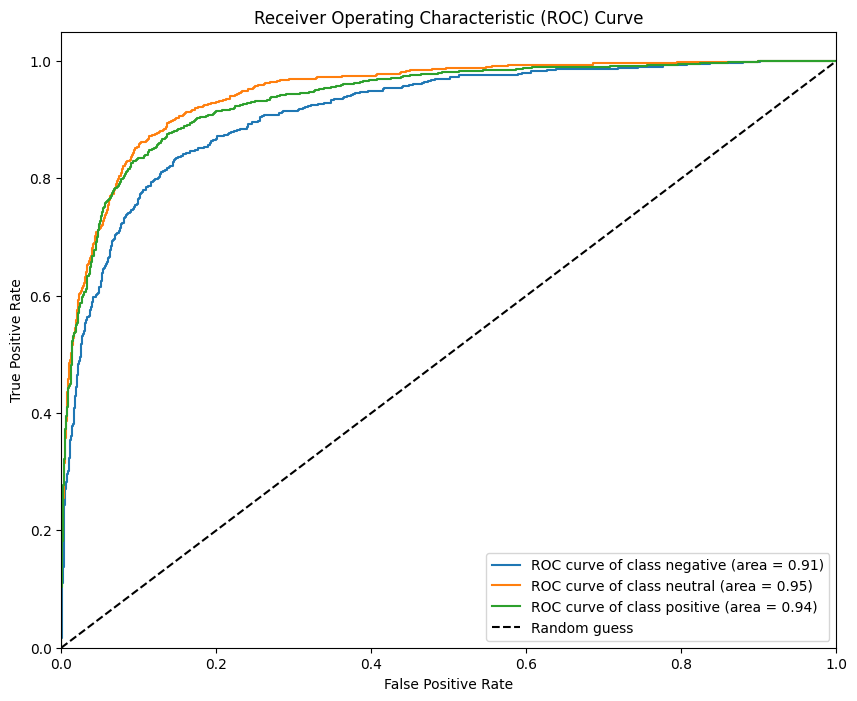

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

classes = np.unique(y)
y_test_binarized = label_binarize(y_test, classes=classes)
y_score = logreg.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=90)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on the test set
dt_preds = dt_model.predict(X_test)

# Evaluate the model
dt_accuracy = accuracy_score(y_test, dt_preds)
dt_f1 = f1_score(y_test, dt_preds, average='weighted')
dt_precision = precision_score(y_test, dt_preds, average='weighted')
dt_recall = recall_score(y_test, dt_preds, average='weighted')
dt_roc_auc = roc_auc_score(y_test,
                           dt_model.predict_proba(X_test),
                           multi_class='ovr')
dt_report = classification_report(y_test, dt_preds)

print(f"Decision Tree Classifier Metrics:")
print(f"Accuracy: {dt_accuracy:.2f}")
print(f"F1 Score: {dt_f1:.2f}")
print(f"Precision: {dt_precision:.2f}")
print(f"Recall: {dt_recall:.2f}")
print("--------------------------------------")
print("Classification Report of Decision Tree:\n", dt_report)

Decision Tree Classifier Metrics:
Accuracy: 0.78
F1 Score: 0.78
Precision: 0.78
Recall: 0.78
--------------------------------------
Classification Report of Decision Tree:
               precision    recall  f1-score   support

    negative       0.55      0.51      0.53       537
     neutral       0.79      0.82      0.80       966
    positive       0.85      0.84      0.85      1800

    accuracy                           0.78      3303
   macro avg       0.73      0.72      0.73      3303
weighted avg       0.78      0.78      0.78      3303



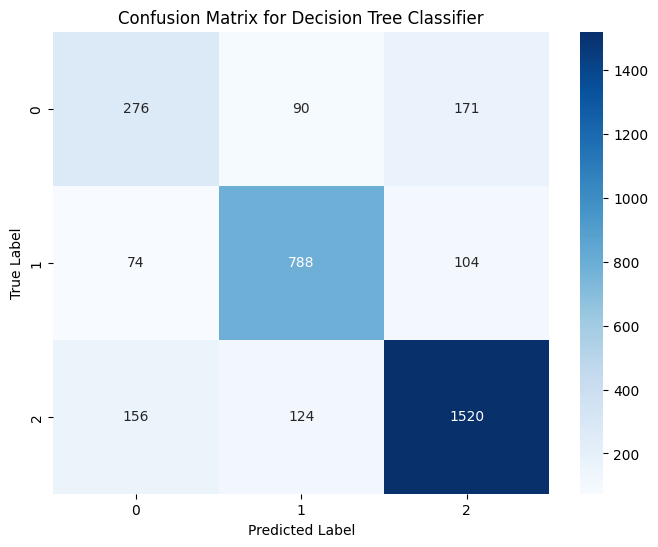

In [ ]:
# Plot confusion matrix for Decision Tree Classifier
conf_matrix_dt = confusion_matrix(y_test, dt_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

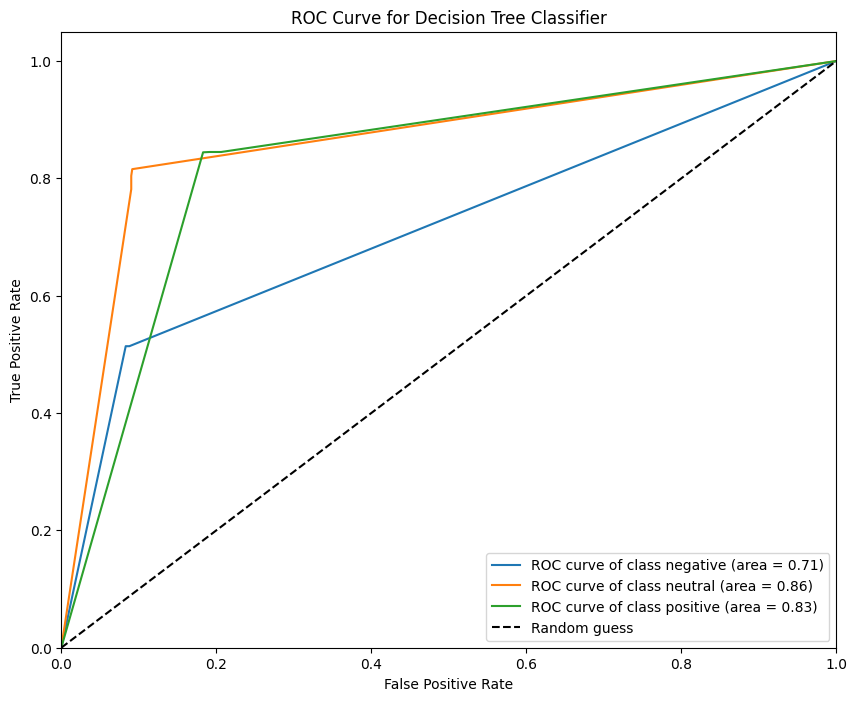

In [ ]:
# Predict probabilities for Decision Tree Classifier
dt_y_score = dt_model.predict_proba(X_test)

# Plot ROC curve for each class for Decision Tree
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class for Decision Tree
fpr_dt = dict()
tpr_dt = dict()
roc_auc_dt = dict()
n_classes = len(classes) # Use the same classes from LogReg

for i in range(n_classes):
    fpr_dt[i], tpr_dt[i], _ = roc_curve(y_test_binarized[:, i],
                                        dt_y_score[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])
    plt.plot(fpr_dt[i], tpr_dt[i],
             label=f'ROC curve of class {classes[i]} (area = {roc_auc_dt[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# prompt: Write a code to perform other classification models along with implementing the metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_preds = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds, average='weighted')
rf_precision = precision_score(y_test, rf_preds, average='weighted')
rf_recall = recall_score(y_test, rf_preds, average='weighted')
# ROC AUC requires probability estimates
rf_roc_auc = roc_auc_score(y_test,
                           rf_model.predict_proba(X_test),
                           multi_class='ovr')
rf_report = classification_report(y_test, rf_preds)

print(f"Random Forest Classifier Metrics:")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"F1 Score: {rf_f1:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")
print(f"ROC AUC Score: {rf_roc_auc:.2f}")
print("--------------------------------------")
print("Classification Report of Random Forest:\n",
      rf_report)

Random Forest Classifier Metrics:
Accuracy: 0.82
F1 Score: 0.81
Precision: 0.82
Recall: 0.82
ROC AUC Score: 0.93
--------------------------------------
Classification Report of Random Forest:
               precision    recall  f1-score   support

    negative       0.80      0.47      0.59       537
     neutral       0.79      0.86      0.83       966
    positive       0.85      0.91      0.88      1800

    accuracy                           0.82      3303
   macro avg       0.81      0.75      0.76      3303
weighted avg       0.82      0.82      0.81      3303



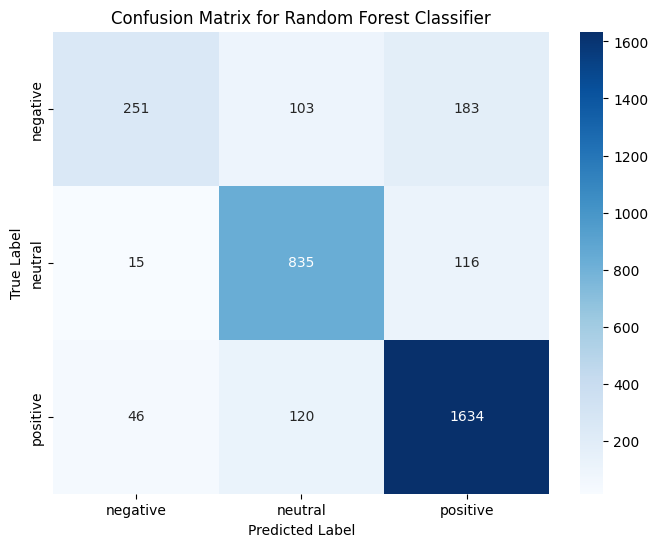

In [ ]:
# Plot confusion matrix for Random Forest Classifier
conf_matrix_rf = confusion_matrix(y_test, rf_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

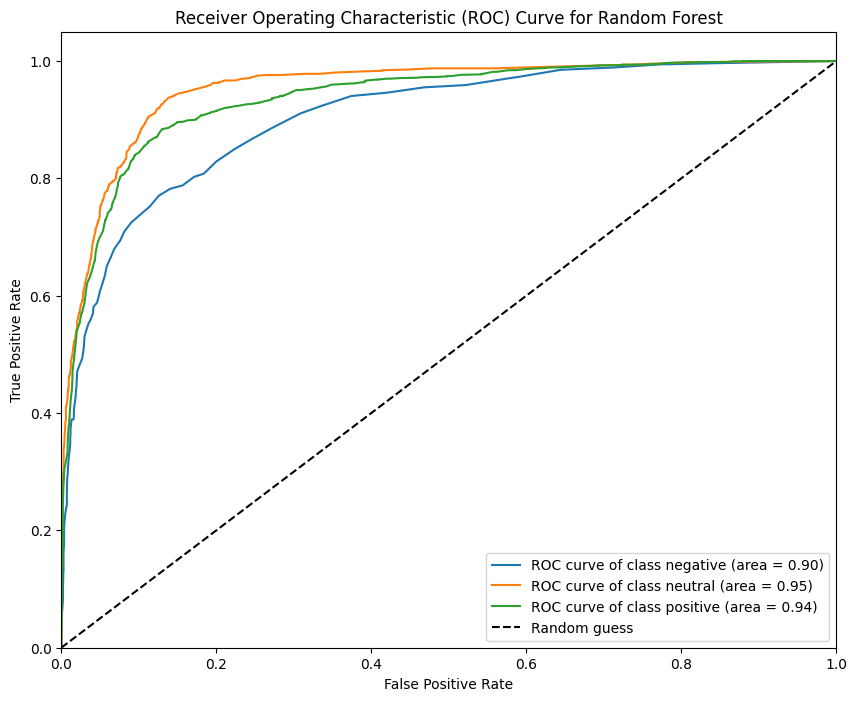

In [ ]:
# Predict probabilities for Random Forest Classifier
rf_y_score = rf_model.predict_proba(X_test)

# Plot ROC curve for each class for Random Forest
plt.figure(figsize=(10, 8))

# Use the same classes from previous plots
classes = np.unique(y)
y_test_binarized = label_binarize(y_test, classes=classes)

# Compute ROC curve and ROC area for each class for Random Forest
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
n_classes = len(classes)

for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized[:, i], rf_y_score[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    plt.plot(fpr_rf[i], tpr_rf[i],
             label=f'ROC curve of class {classes[i]} (area = {roc_auc_rf[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Initialize the K-Nearest Neighbors Classifier
# Choose n_neighbors (e.g., 5)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
knn_preds = knn_model.predict(X_test)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, knn_preds)
knn_f1 = f1_score(y_test, knn_preds, average='weighted')
knn_precision = precision_score(y_test, knn_preds, average='weighted')
knn_recall = recall_score(y_test, knn_preds, average='weighted')
knn_roc_auc = roc_auc_score(y_test,
                            knn_model.predict_proba(X_test),
                            multi_class='ovr')
knn_report = classification_report(y_test, knn_preds)

print(f"\nK-Nearest Neighbors (KNN) Classifier Metrics:")
print(f"Accuracy: {knn_accuracy:.2f}")
print(f"F1 Score: {knn_f1:.2f}")
print(f"Precision: {knn_precision:.2f}")
print(f"Recall: {knn_recall:.2f}")
print(f"ROC AUC Score: {knn_roc_auc:.2f}")
print("--------------------------------------")
print("Classification Report of KNN:\n", knn_report)


K-Nearest Neighbors (KNN) Classifier Metrics:
Accuracy: 0.53
F1 Score: 0.52
Precision: 0.66
Recall: 0.53
ROC AUC Score: 0.74
--------------------------------------
Classification Report of KNN:
               precision    recall  f1-score   support

    negative       0.61      0.18      0.27       537
     neutral       0.39      0.88      0.54       966
    positive       0.83      0.44      0.58      1800

    accuracy                           0.53      3303
   macro avg       0.61      0.50      0.46      3303
weighted avg       0.66      0.53      0.52      3303



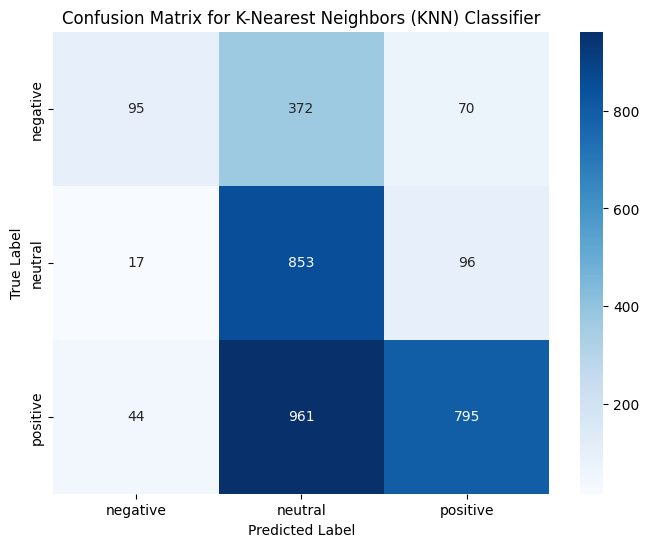

In [ ]:
# Plot confusion matrix for KNN Classifier
conf_matrix_knn = confusion_matrix(y_test, knn_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.title('Confusion Matrix for K-Nearest Neighbors (KNN) Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

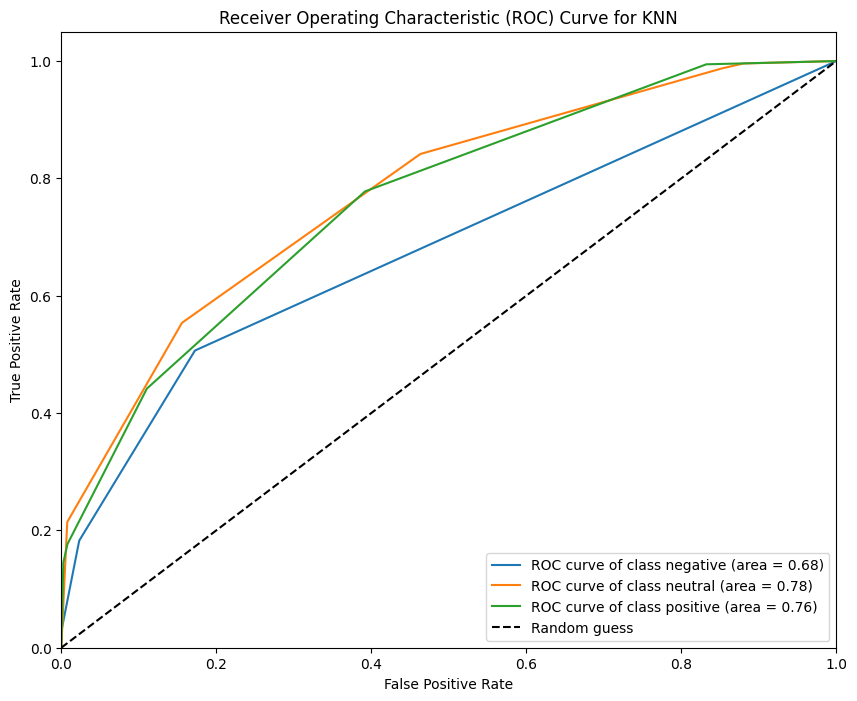

In [ ]:
# Predict probabilities for KNN Classifier
knn_y_score = knn_model.predict_proba(X_test)

# Plot ROC curve for each class for KNN
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class for KNN
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
n_classes = len(classes)

for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_binarized[:, i], knn_y_score[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])
    plt.plot(fpr_knn[i], tpr_knn[i],
             label=f'ROC curve of class {classes[i]} (area = {roc_auc_knn[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Initialize and train MLP (Multi-layer Perceptron) Classifier
# Adjust hidden_layer_sizes and max_iter as needed
mlp_model = MLPClassifier(hidden_layer_sizes=(100,),
                          max_iter=500, random_state=42)
print("\nTraining MLP Classifier...")
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_test)

# Evaluate MLP Classifier
mlp_accuracy = accuracy_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds, average='weighted')
mlp_precision = precision_score(y_test, mlp_preds, average='weighted')
mlp_recall = recall_score(y_test, mlp_preds, average='weighted')
mlp_roc_auc = roc_auc_score(y_test, mlp_model.predict_proba(X_test), multi_class='ovr')
mlp_report = classification_report(y_test, mlp_preds)

print(f"\nMulti-layer Perceptron (MLP) Classifier Metrics:")
print(f"Accuracy: {mlp_accuracy:.2f}")
print(f"F1 Score: {mlp_f1:.2f}")
print(f"Precision: {mlp_precision:.2f}")
print(f"Recall: {mlp_recall:.2f}")
print(f"ROC AUC Score: {mlp_roc_auc:.2f}")
print("--------------------------------------")
print("Classification Report of MLP:\n", mlp_report)


Training MLP Classifier...

Multi-layer Perceptron (MLP) Classifier Metrics:
Accuracy: 0.80
F1 Score: 0.80
Precision: 0.81
Recall: 0.80
ROC AUC Score: 0.91
--------------------------------------
Classification Report of MLP:
               precision    recall  f1-score   support

    negative       0.61      0.63      0.62       537
     neutral       0.79      0.80      0.80       966
    positive       0.87      0.85      0.86      1800

    accuracy                           0.80      3303
   macro avg       0.76      0.76      0.76      3303
weighted avg       0.81      0.80      0.80      3303



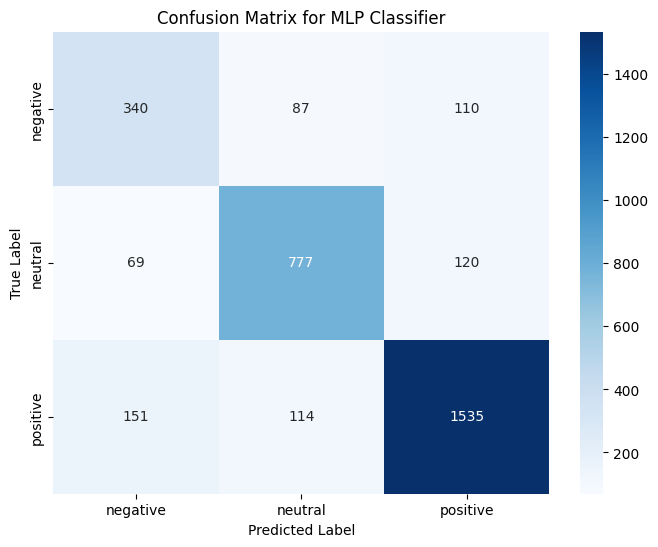

In [ ]:
# Plot confusion matrix for MLP Classifier
conf_matrix_mlp = confusion_matrix(y_test, mlp_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=mlp_model.classes_, yticklabels=mlp_model.classes_)
plt.title('Confusion Matrix for MLP Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

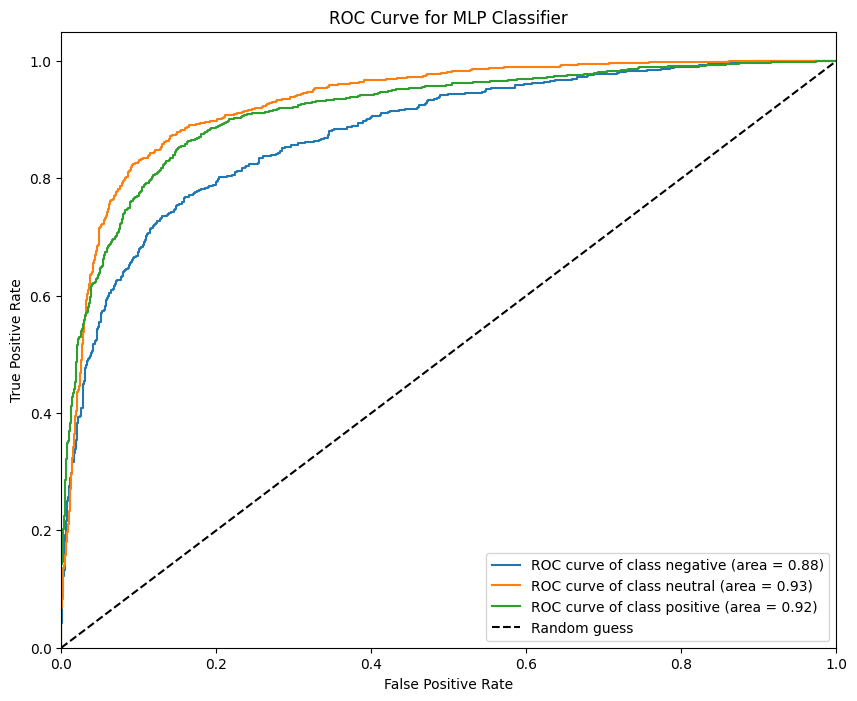

In [ ]:
# Plot ROC curve for MLP
mlp_y_score = mlp_model.predict_proba(X_test)
plt.figure(figsize=(10, 8))
fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()
for i in range(len(classes)):
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(y_test_binarized[:, i], mlp_y_score[:, i])
    roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])
    plt.plot(fpr_mlp[i], tpr_mlp[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc_mlp[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP Classifier')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Initialize and train Gaussian Naive Bayes
gnb_model = GaussianNB()
print("\nTraining Gaussian Naive Bayes...")
gnb_model.fit(X_train.toarray(), y_train)
gnb_preds = gnb_model.predict(X_test.toarray())

# # Evaluate Gaussian Naive Bayes
gnb_accuracy = accuracy_score(y_test, gnb_preds)
gnb_f1 = f1_score(y_test, gnb_preds, average='weighted')
gnb_precision = precision_score(y_test, gnb_preds, average='weighted')
gnb_recall = recall_score(y_test, gnb_preds, average='weighted')
gnb_roc_auc = roc_auc_score(y_test, gnb_model.predict_proba(X_test.toarray()), multi_class='ovr')
gnb_report = classification_report(y_test, gnb_preds)

print(f"\nGaussian Naive Bayes Classifier Metrics:")
print(f"Accuracy: {gnb_accuracy:.2f}")
print(f"F1 Score: {gnb_f1:.2f}")
print(f"Precision: {gnb_precision:.2f}")
print(f"Recall: {gnb_recall:.2f}")
print(f"ROC AUC Score: {gnb_roc_auc:.2f}")
print("--------------------------------------")
print("Classification Report of Gaussian Naive Bayes:\n", gnb_report)


Training Gaussian Naive Bayes...

Gaussian Naive Bayes Classifier Metrics:
Accuracy: 0.57
F1 Score: 0.58
Precision: 0.71
Recall: 0.57
ROC AUC Score: 0.74
--------------------------------------
Classification Report of Gaussian Naive Bayes:
               precision    recall  f1-score   support

    negative       0.30      0.69      0.41       537
     neutral       0.64      0.81      0.72       966
    positive       0.87      0.40      0.55      1800

    accuracy                           0.57      3303
   macro avg       0.60      0.63      0.56      3303
weighted avg       0.71      0.57      0.58      3303



In [ ]:
# Initialize and train Linear Discriminant Analysis (LDA)
# LDA requires dense input
lda_model = LinearDiscriminantAnalysis()
print("\nTraining Linear Discriminant Analysis...")
lda_model.fit(X_train.toarray(), y_train)
lda_preds = lda_model.predict(X_test.toarray())

# Evaluate LDA
lda_accuracy = accuracy_score(y_test, lda_preds)
lda_f1 = f1_score(y_test, lda_preds, average='weighted')
lda_precision = precision_score(y_test, lda_preds, average='weighted')
lda_recall = recall_score(y_test, lda_preds, average='weighted')
# LDA predict_proba might raise an error if the number of samples is too small for the number of features
# Handle this potential error gracefully
try:
    lda_roc_auc = roc_auc_score(y_test, lda_model.predict_proba(X_test.toarray()), multi_class='ovr')
except ValueError as e:
    print(f"Could not compute ROC AUC for LDA: {e}")
    lda_roc_auc = np.nan # Assign NaN if ROC AUC cannot be computed

lda_report = classification_report(y_test, lda_preds)

print(f"\nLinear Discriminant Analysis (LDA) Classifier Metrics:")
print(f"Accuracy: {lda_accuracy:.2f}")
print(f"F1 Score: {lda_f1:.2f}")
print(f"Precision: {lda_precision:.2f}")
print(f"Recall: {lda_recall:.2f}")
if not np.isnan(lda_roc_auc):
     print(f"ROC AUC Score: {lda_roc_auc:.2f}")
else:
    print(f"ROC AUC Score: N/A (could not compute)")
print("--------------------------------------")
print("Classification Report of LDA:\n", lda_report)


Training Linear Discriminant Analysis...

Linear Discriminant Analysis (LDA) Classifier Metrics:
Accuracy: 0.79
F1 Score: 0.79
Precision: 0.80
Recall: 0.79
ROC AUC Score: 0.91
--------------------------------------
Classification Report of LDA:
               precision    recall  f1-score   support

    negative       0.67      0.66      0.66       537
     neutral       0.74      0.81      0.78       966
    positive       0.86      0.82      0.84      1800

    accuracy                           0.79      3303
   macro avg       0.76      0.76      0.76      3303
weighted avg       0.80      0.79      0.79      3303



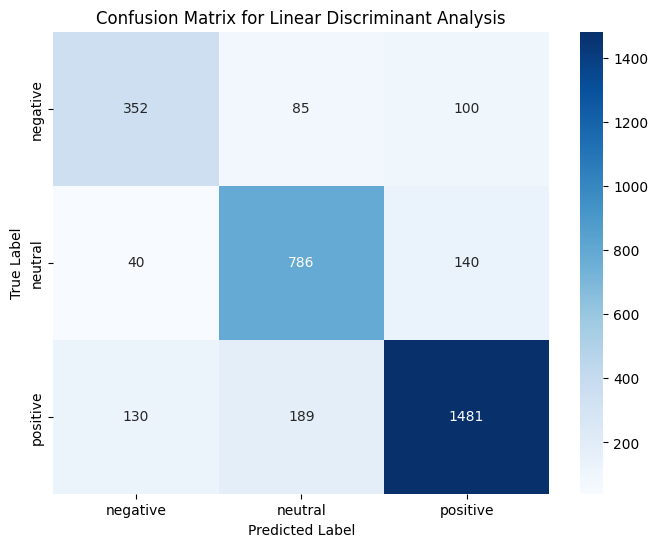

In [ ]:
# Plot confusion matrix for LDA Classifier
conf_matrix_lda = confusion_matrix(y_test, lda_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lda, annot=True, fmt='d', cmap='Blues', xticklabels=lda_model.classes_, yticklabels=lda_model.classes_)
plt.title('Confusion Matrix for Linear Discriminant Analysis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

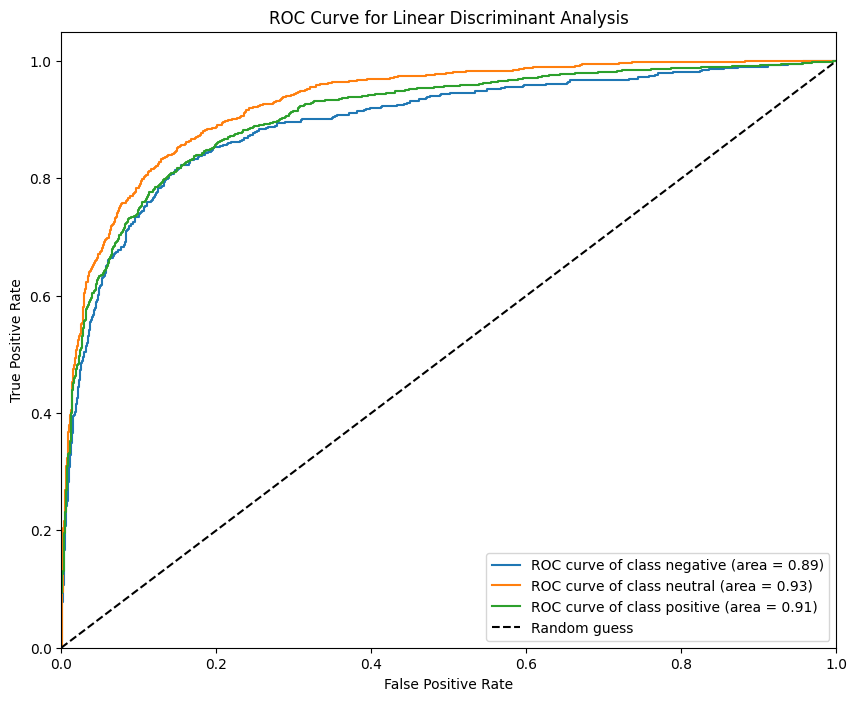

In [ ]:
# Plot ROC curve for LDA
if not np.isnan(lda_roc_auc):
    lda_y_score = lda_model.predict_proba(X_test.toarray())
    plt.figure(figsize=(10, 8))
    fpr_lda = dict()
    tpr_lda = dict()
    roc_auc_lda = dict()
    for i in range(len(classes)):
        fpr_lda[i], tpr_lda[i], _ = roc_curve(y_test_binarized[:, i], lda_y_score[:, i])
        roc_auc_lda[i] = auc(fpr_lda[i], tpr_lda[i])
        plt.plot(fpr_lda[i], tpr_lda[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc_lda[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Linear Discriminant Analysis')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve not plotted for LDA due to inability to compute ROC AUC.")

In [ ]:
# Initialize and train Quadratic Discriminant Analysis (QDA)
# QDA requires dense input and can be more sensitive to feature correlations.
qda_model = QuadraticDiscriminantAnalysis()
print("\nTraining Quadratic Discriminant Analysis...")
# Check if the number of samples is greater than the number of classes
if X_train.shape[0] > len(np.unique(y_train)):
  try:
    qda_model.fit(X_train.toarray(), y_train)
    qda_preds = qda_model.predict(X_test.toarray())
    # Evaluate QDA
    qda_accuracy = accuracy_score(y_test, qda_preds)
    qda_f1 = f1_score(y_test, qda_preds, average='weighted')
    qda_precision = precision_score(y_test, qda_preds, average='weighted')
    qda_recall = recall_score(y_test, qda_preds, average='weighted')
    try:
      qda_roc_auc = roc_auc_score(y_test, qda_model.predict_proba(X_test.toarray()), multi_class='ovr')
    except ValueError as e:
      print(f"Could not compute ROC AUC for QDA: {e}")
      qda_roc_auc = np.nan

    qda_report = classification_report(y_test, qda_preds)

    print(f"\nQuadratic Discriminant Analysis (QDA) Classifier Metrics:")
    print(f"Accuracy: {qda_accuracy:.2f}")
    print(f"F1 Score: {qda_f1:.2f}")
    print(f"Precision: {qda_precision:.2f}")
    print(f"Recall: {qda_recall:.2f}")
    if not np.isnan(qda_roc_auc):
      print(f"ROC AUC Score: {qda_roc_auc:.2f}")
    else:
      print(f"ROC AUC Score: N/A (could not compute)")
    print("--------------------------------------")
    print("Classification Report of QDA:\n", qda_report)

  except Exception as e:
       print(f"\nCould not train or evaluate QDA due to an error: {e}")
else:
    print("\nSkipping QDA: Number of samples in training data is not greater than the number of classes.")


Training Quadratic Discriminant Analysis...

Quadratic Discriminant Analysis (QDA) Classifier Metrics:
Accuracy: 0.72
F1 Score: 0.66
Precision: 0.76
Recall: 0.72
ROC AUC Score: 0.68
--------------------------------------
Classification Report of QDA:
               precision    recall  f1-score   support

    negative       0.87      0.05      0.09       537
     neutral       0.85      0.65      0.74       966
    positive       0.68      0.96      0.79      1800

    accuracy                           0.72      3303
   macro avg       0.80      0.55      0.54      3303
weighted avg       0.76      0.72      0.66      3303



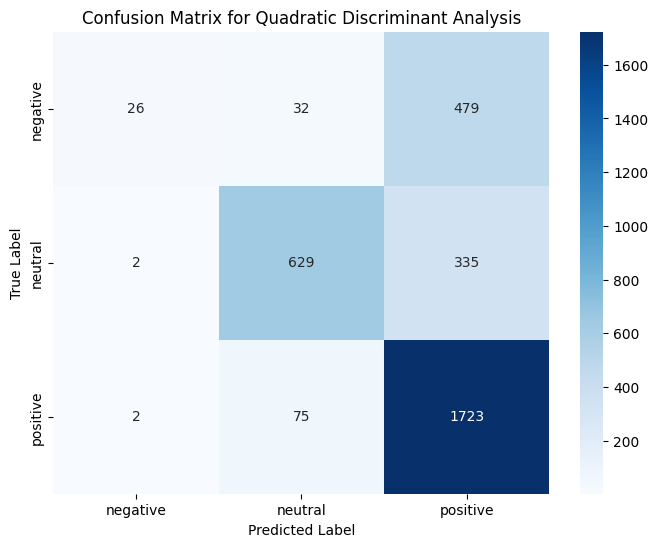

In [ ]:
#Plot confusion matrix for QDA Classifier
conf_matrix_qda = confusion_matrix(y_test, qda_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qda, annot=True, fmt='d', cmap='Blues', xticklabels=qda_model.classes_, yticklabels=qda_model.classes_)
plt.title('Confusion Matrix for Quadratic Discriminant Analysis')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

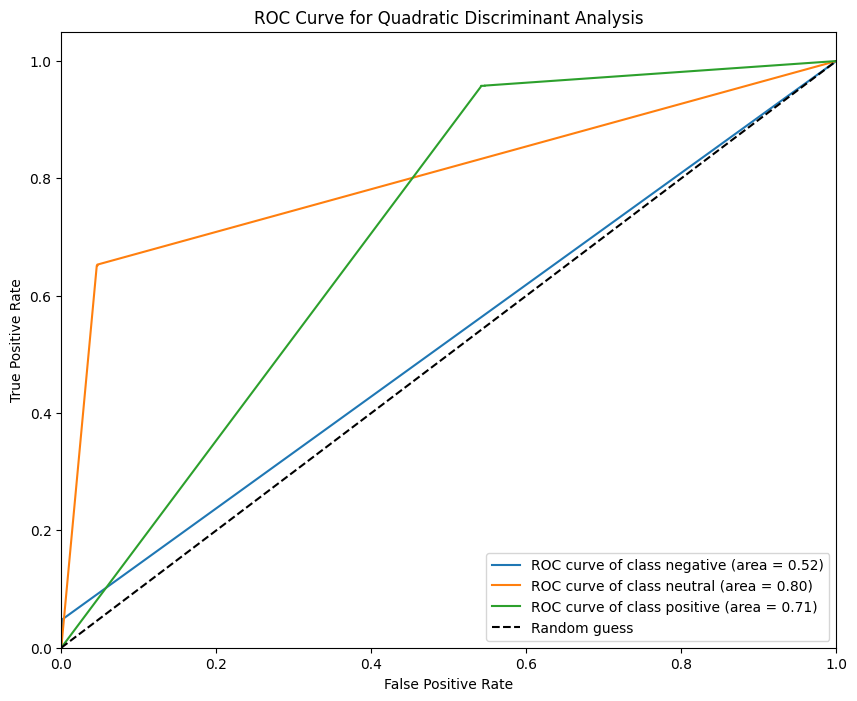

In [ ]:
# Plot ROC curve for QDA
if not np.isnan(qda_roc_auc):
  qda_y_score = qda_model.predict_proba(X_test.toarray())
  plt.figure(figsize=(10, 8))
  fpr_qda = dict()
  tpr_qda = dict()
  roc_auc_qda = dict()
  for i in range(len(classes)):
    fpr_qda[i], tpr_qda[i], _ = roc_curve(y_test_binarized[:, i], qda_y_score[:, i])
    roc_auc_qda[i] = auc(fpr_qda[i], tpr_qda[i])
    plt.plot(fpr_qda[i], tpr_qda[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc_qda[i]:0.2f})')
  plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Quadratic Discriminant Analysis')
  plt.legend(loc="lower right")
  plt.show()
else:
    print("ROC curve not plotted for QDA due to inability to compute ROC AUC.")

In [ ]:
# Create a dictionary to store evaluation results
model_results = {
    'Model': [],
    'Accuracy': [],
    'F1 Score (Weighted)': [],
    'Precision (Weighted)': [],
    'Recall (Weighted)': [],
    'ROC AUC Score (OvR)': []
}

# Add results for each trained model
model_results['Model'].extend(['Naive Bayes (Multinomial)', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'MLP'])
model_results['Accuracy'].extend([nb_accuracy, logreg_accuracy, dt_accuracy, rf_accuracy, knn_accuracy, mlp_accuracy])
model_results['F1 Score (Weighted)'].extend([nb_f1, logreg_f1, dt_f1, rf_f1, knn_f1, mlp_f1])
model_results['Precision (Weighted)'].extend([nb_precision, logreg_precision, dt_precision, rf_precision, knn_precision, mlp_precision])
model_results['Recall (Weighted)'].extend([nb_recall, logreg_recall, dt_recall, rf_recall, knn_recall, mlp_recall])
model_results['ROC AUC Score (OvR)'].extend([nb_roc_auc, logreg_roc_auc, dt_roc_auc, rf_roc_auc, knn_roc_auc, mlp_roc_auc])

# Add Gaussian Naive Bayes results (requires dense input)
if 'gnb_accuracy' in locals(): # Check if GNB was successfully trained
    model_results['Model'].append('Naive Bayes (Gaussian)')
    model_results['Accuracy'].append(gnb_accuracy)
    model_results['F1 Score (Weighted)'].append(gnb_f1)
    model_results['Precision (Weighted)'].append(gnb_precision)
    model_results['Recall (Weighted)'].append(gnb_recall)
    model_results['ROC AUC Score (OvR)'].append(gnb_roc_auc)

# Add LDA results (requires dense input)
if 'lda_accuracy' in locals(): # Check if LDA was successfully trained
    model_results['Model'].append('LDA')
    model_results['Accuracy'].append(lda_accuracy)
    model_results['F1 Score (Weighted)'].append(lda_f1)
    model_results['Precision (Weighted)'].append(lda_precision)
    model_results['Recall (Weighted)'].append(lda_recall)
    # Check if LDA ROC AUC was computed successfully
    if not np.isnan(lda_roc_auc):
         model_results['ROC AUC Score (OvR)'].append(lda_roc_auc)
    else:
        model_results['ROC AUC Score (OvR)'].append(np.nan)


# Add QDA results (requires dense input)
if 'qda_accuracy' in locals(): # Check if QDA was successfully trained
    model_results['Model'].append('QDA')
    model_results['Accuracy'].append(qda_accuracy)
    model_results['F1 Score (Weighted)'].append(qda_f1)
    model_results['Precision (Weighted)'].append(qda_precision)
    model_results['Recall (Weighted)'].append(qda_recall)
     # Check if QDA ROC AUC was computed successfully
    if not np.isnan(qda_roc_auc):
         model_results['ROC AUC Score (OvR)'].append(qda_roc_auc)
    else:
        model_results['ROC AUC Score (OvR)'].append(np.nan)


# Create a DataFrame from the results
results_df = pd.DataFrame(model_results)

# Sort models by a primary metric, e.g., F1 Score or Accuracy
results_df_sorted = results_df.sort_values(by='F1 Score (Weighted)', ascending=False)

print("\n--- Model Performance Comparison ---")
results_df_sorted


--- Model Performance Comparison ---


,Model,Accuracy,F1 Score (Weighted),Precision (Weighted),Recall (Weighted),ROC AUC Score (OvR)
3,Random Forest,0.823494,0.814517,0.822275,0.823494,0.931069
1,Logistic Regression,0.818952,0.811358,0.817571,0.818952,0.932409
5,MLP,0.802906,0.803859,0.805008,0.802906,0.908086
7,LDA,0.792916,0.793444,0.795458,0.792916,0.910314
2,Decision Tree,0.782319,0.781079,0.780149,0.782319,0.801493
8,QDA,0.719952,0.664079,0.760954,0.719952,0.678236
0,Naive Bayes (Multinomial),0.691190,0.657794,0.727660,0.691190,0.883966
6,Naive Bayes (Gaussian),0.567363,0.575363,0.710906,0.567363,0.736732
4,KNN,0.527702,0.516697,0.663953,0.527702,0.738080


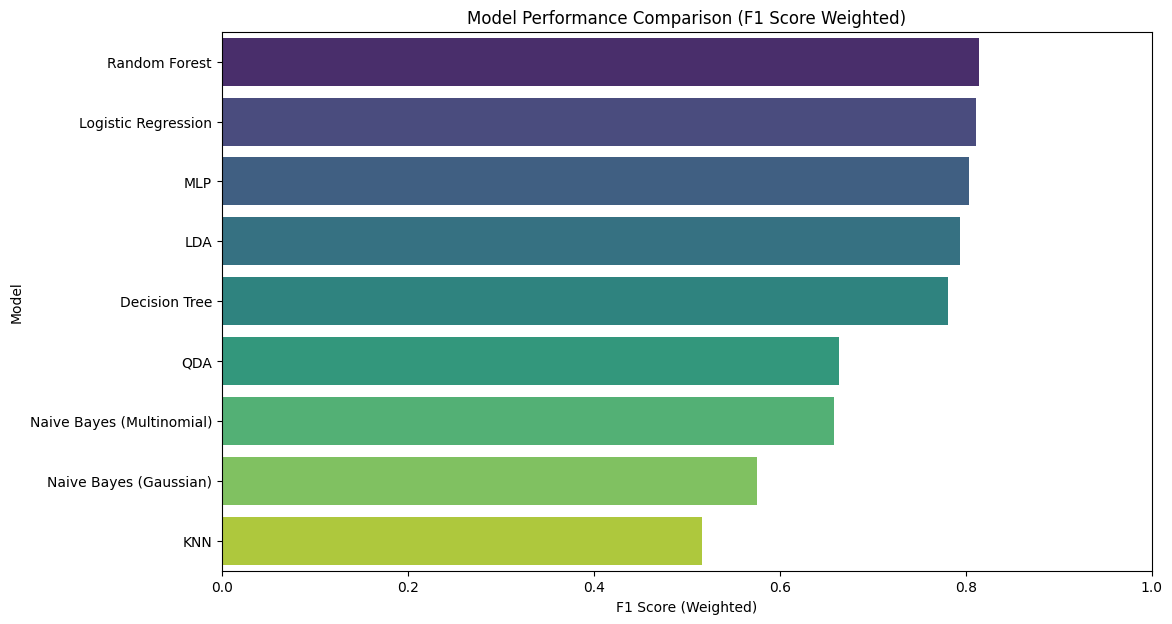

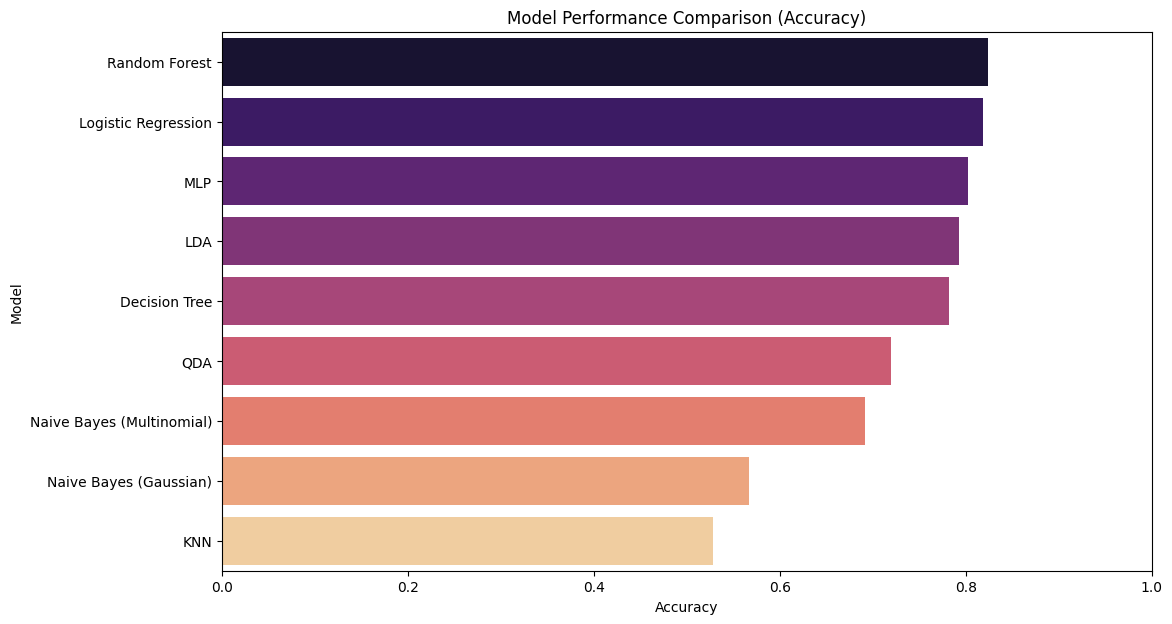

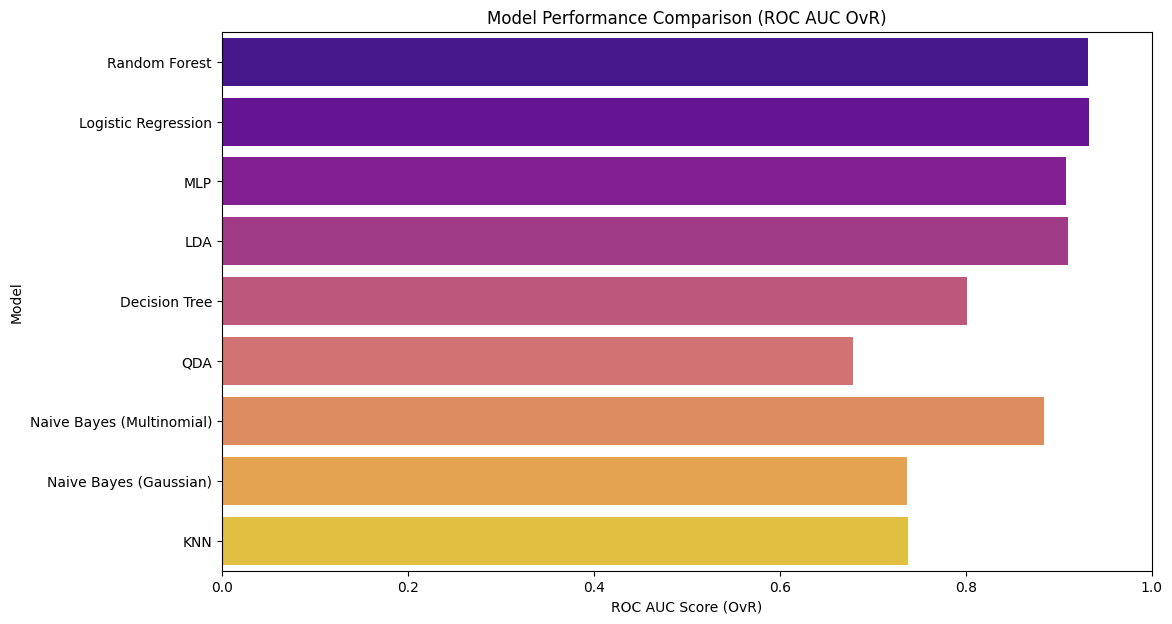

In [ ]:
# You can further analyze or visualize these results
plt.figure(figsize=(12, 7))
sns.barplot(x='F1 Score (Weighted)', y='Model', data=results_df_sorted, palette='viridis')
plt.title('Model Performance Comparison (F1 Score Weighted)')
plt.xlabel('F1 Score (Weighted)')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(12, 7))
sns.barplot(x='Accuracy', y='Model', data=results_df_sorted, palette='magma')
plt.title('Model Performance Comparison (Accuracy)')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.show()

# You can also compare ROC AUC if available for all models
if not results_df_sorted['ROC AUC Score (OvR)'].isnull().all():
    plt.figure(figsize=(12, 7))
    # Filter out rows where ROC AUC is NaN for plotting
    roc_auc_plot_df = results_df_sorted.dropna(subset=['ROC AUC Score (OvR)'])
    sns.barplot(x='ROC AUC Score (OvR)', y='Model', data=roc_auc_plot_df, palette='plasma')
    plt.title('Model Performance Comparison (ROC AUC OvR)')
    plt.xlabel('ROC AUC Score (OvR)')
    plt.ylabel('Model')
    plt.xlim(0, 1)
    plt.show()

In [ ]:
best_model_f1_weighted = results_df['F1 Score (Weighted)'].idxmax()
print(f"Best Model based on F1 Score (Weighted): {results_df['Model'][best_model_f1_weighted]}")

best_model_accuracy = results_df['Accuracy'].idxmax()
print(f"Best Model based on Accuracy: {results_df['Model'][best_model_accuracy]}")

best_model_precision_weighted = results_df['Precision (Weighted)'].idxmax()
print(f"Best Model based on Precision (Weighted): {results_df['Model'][best_model_precision_weighted]}")

best_model_recall_weighted = results_df['Recall (Weighted)'].idxmax()
print(f"Best Model based on Recall (Weighted): {results_df['Model'][best_model_recall_weighted]}")

best_model_roc_ovr = results_df['ROC AUC Score (OvR)'].idxmax()
print(f"Best Model based on ROC AUC (OvR): {results_df['Model'][best_model_roc_ovr]}")

Best Model based on F1 Score (Weighted): Random Forest
Best Model based on Accuracy: Random Forest
Best Model based on Precision (Weighted): Random Forest
Best Model based on Recall (Weighted): Random Forest
Best Model based on ROC AUC (OvR): Logistic Regression
